In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13697776897404751380, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 13680180362657198916
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 2696980805211975280
 physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1", name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 9137020807033920852
 physical_device_desc: "device: 2, name: GeForce GTX 1080 Ti, pci bus id: 0000:87:00.0, compute capability: 6.1", name: "/device:GPU:3"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 1189357325966942488
 physical_devi

In [3]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.4.0
dim_ordering: tf


Using TensorFlow backend.


In [4]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model

from keras.layers.core import Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model

from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [5]:
output_classes = 2
batch_size = 16
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 103104
nb_validation_samples = 12288
nb_test_samples = 697

In [6]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test'

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 103104 images belonging to 2 classes.
Found 12288 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [12]:
"""SE-ResNet-50 model for Keras.
Based on https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py
"""
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Reshape
from keras.layers import Multiply
from keras.models import Model
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras_applications.imagenet_utils import _obtain_input_shape


def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[..., ::-1]
    
    # Zero-center by mean pixel
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68

    # Scale
    x *= 0.017
    return x
  
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    bn_eps = 0.0001
        
    block_name = str(stage) + "_" + str(block)
    conv_name_base = "conv" + block_name
    relu_name_base = "relu" + block_name

    x = Conv2D(filters1, (1, 1), use_bias=False, name=conv_name_base + '_x1')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x1_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x1')(x)

    x = Conv2D(filters2, kernel_size, padding='same', use_bias=False, name=conv_name_base + '_x2')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x2_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x2')(x)

    x = Conv2D(filters3, (1, 1), use_bias=False, name=conv_name_base + '_x3')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x3_bn')(x)

    se = GlobalAveragePooling2D(name='pool' + block_name + '_gap')(x)
    se = Dense(filters3 // 16, activation='relu', name = 'fc' + block_name + '_sqz')(se)
    se = Dense(filters3, activation='sigmoid', name = 'fc' + block_name + '_exc')(se)
    se = Reshape([1, 1, filters3])(se)
    x = Multiply(name='scale' + block_name)([x, se])

    x = layers.add([x, input_tensor], name='block_' + block_name)
    x = Activation('relu', name=relu_name_base)(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    bn_eps = 0.0001
    
    block_name = str(stage) + "_" + str(block)
    conv_name_base = "conv" + block_name
    relu_name_base = "relu" + block_name

    x = Conv2D(filters1, (1, 1), use_bias=False, name=conv_name_base + '_x1')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x1_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x1')(x)

    x = Conv2D(filters2, kernel_size, strides=strides, padding='same', use_bias=False, name=conv_name_base + '_x2')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x2_bn')(x)
    x = Activation('relu', name=relu_name_base + '_x2')(x)

    x = Conv2D(filters3, (1, 1), use_bias=False, name=conv_name_base + '_x3')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_x3_bn')(x)
    
    se = GlobalAveragePooling2D(name='pool' + block_name + '_gap')(x)
    se = Dense(filters3 // 16, activation='relu', name = 'fc' + block_name + '_sqz')(se)
    se = Dense(filters3, activation='sigmoid', name = 'fc' + block_name + '_exc')(se)
    se = Reshape([1, 1, filters3])(se)
    x = Multiply(name='scale' + block_name)([x, se])
    
    shortcut = Conv2D(filters3, (1, 1), strides=strides, use_bias=False, name=conv_name_base + '_prj')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name=conv_name_base + '_prj_bn')(shortcut)

    x = layers.add([x, shortcut], name='block_' + block_name)
    x = Activation('relu', name=relu_name_base)(x)
    return x


def SEResNet50(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=225,
                                      min_size=160,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    bn_eps = 0.0001

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False, name='conv1')(img_input)
    x = BatchNormalization(axis=bn_axis, epsilon=bn_eps, name='conv1_bn')(x)
    x = Activation('relu', name='relu1')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=2)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=3)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block=1)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=3)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=4)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block=1)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=3)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=4)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=5)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=6)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block=1)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=3)

    x = Flatten()(x)
    x = Dense(classes, activation=tf.nn.softmax, name='fc6')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='se-resnet50')
    return model

In [13]:
model = SEResNet50(weights=None, input_shape=(224, 224, 3), classes=2)

In [14]:
# sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
# adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=True)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)

model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [15]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose = 1)]

history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = callbacks)

# with open('models/vgg19_history.txt','w') as f:
#     f.write(str(history.history))

Epoch 1/50
6444/6444 [==============================] - 1277s 198ms/step - loss: 0.4927 - acc: 0.8380 - val_loss: 0.4488 - val_acc: 0.8014
Epoch 2/50
6444/6444 [==============================] - 1305s 202ms/step - loss: 0.2183 - acc: 0.9142 - val_loss: 0.5512 - val_acc: 0.8319
Epoch 3/50
6444/6444 [==============================] - 1275s 198ms/step - loss: 0.1258 - acc: 0.9544 - val_loss: 0.4004 - val_acc: 0.8674
Epoch 4/50
6444/6444 [==============================] - 1274s 198ms/step - loss: 0.0984 - acc: 0.9664 - val_loss: 0.4403 - val_acc: 0.8586
Epoch 5/50
6444/6444 [==============================] - 1273s 198ms/step - loss: 0.0620 - acc: 0.9816 - val_loss: 0.4269 - val_acc: 0.8625
Epoch 6/50
6444/6444 [==============================] - 1272s 197ms/step - loss: 0.0408 - acc: 0.9872 - val_loss: 0.4746 - val_acc: 0.8687
Epoch 7/50
6444/6444 [==============================] - 1282s 199ms/step - loss: 0.0366 - acc: 0.9893 - val_loss: 0.5470 - val_acc: 0.8464
Epoch 8/50
6444/6444 [=====

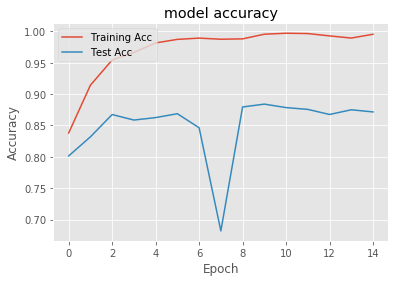

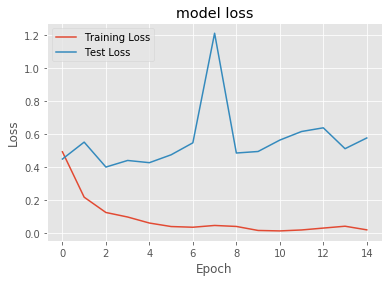

In [16]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

# plt.figure()
# N = epochs
# plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="upper left")

In [17]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.4694257024722174
Validation Accuracy:  0.88875


In [18]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

44/43 [==============================] - 9s 204ms/step
No of errors = 71/697


Confusion Matrix
[[174  42]
 [ 29 452]]


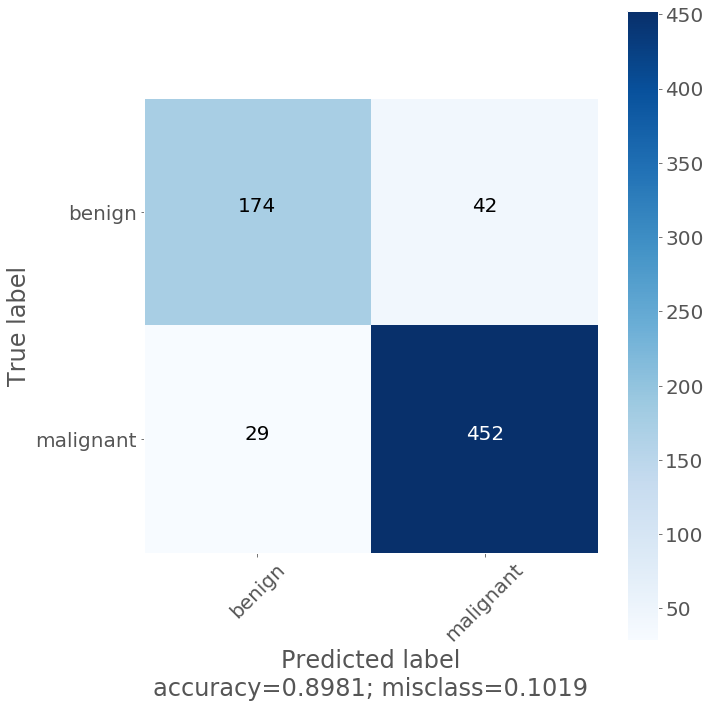

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[174  42]
 [ 29 452]]
              precision    recall  f1-score   support

      benign       0.86      0.81      0.83       216
   malignant       0.91      0.94      0.93       481

   micro avg       0.90      0.90      0.90       697
   macro avg       0.89      0.87      0.88       697
weighted avg       0.90      0.90      0.90       697



In [21]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  89.81348637015782
Sensitivity :  85.71428571428571
Specificity :  91.49797570850203


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  89.8135
Precision: 91.4980
Recall:    93.9709
F1:        92.7179


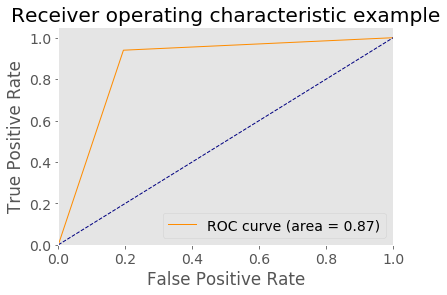

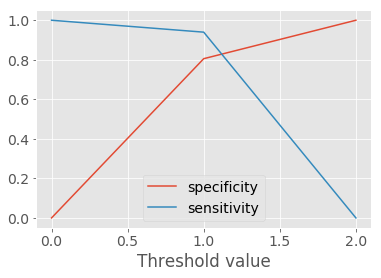

In [23]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [24]:
model.save('models/20.SEResNet50-BreaKHis-Model.h5')
model.save_weights('models/20.SEResNet50-BreaKHis-Weights.h5')

___

In [25]:
adam_opt2=Adam(lr=1e-05, beta_1=0.6, beta_2=0.9, epsilon=None, decay=0.0, amsgrad=True)
model.compile(optimizer= adam_opt2, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [26]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose = 1)]

history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = callbacks)

# with open('models/vgg19_history2.txt','w') as f:
#     f.write(str(history.history))

Epoch 1/50
6444/6444 [==============================] - 1302s 202ms/step - loss: 0.0104 - acc: 0.9981 - val_loss: 0.5805 - val_acc: 0.8784
Epoch 2/50
6444/6444 [==============================] - 1282s 199ms/step - loss: 0.0074 - acc: 0.9989 - val_loss: 0.5756 - val_acc: 0.8801
Epoch 3/50
6444/6444 [==============================] - 1297s 201ms/step - loss: 0.0085 - acc: 0.9987 - val_loss: 0.5622 - val_acc: 0.8814
Epoch 4/50
6444/6444 [==============================] - 1306s 203ms/step - loss: 0.0061 - acc: 0.9990 - val_loss: 0.5899 - val_acc: 0.8802
Epoch 5/50
6444/6444 [==============================] - 1297s 201ms/step - loss: 0.0059 - acc: 0.9991 - val_loss: 0.5883 - val_acc: 0.8815
Epoch 6/50
6444/6444 [==============================] - 1293s 201ms/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.6107 - val_acc: 0.8808
Epoch 7/50
6444/6444 [==============================] - 1293s 201ms/step - loss: 0.0070 - acc: 0.9992 - val_loss: 0.6079 - val_acc: 0.8807
Epoch 8/50
6444/6444 [=====

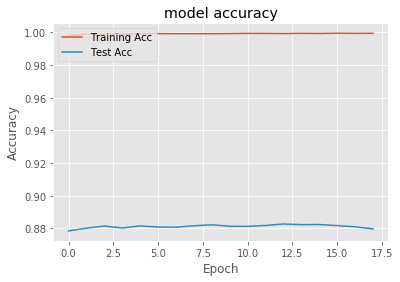

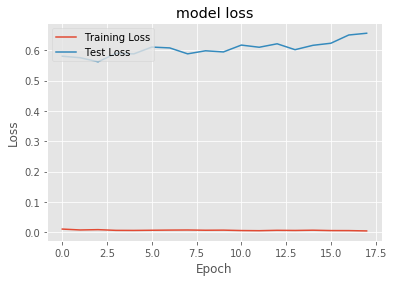

In [27]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

# plt.figure()
# N = 12
# plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="upper left")

In [28]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.8176602088450454
Validation Accuracy:  0.86375


In [29]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

44/43 [==============================] - 11s 241ms/step
No of errors = 69/697


Confusion Matrix
[[173  43]
 [ 26 455]]


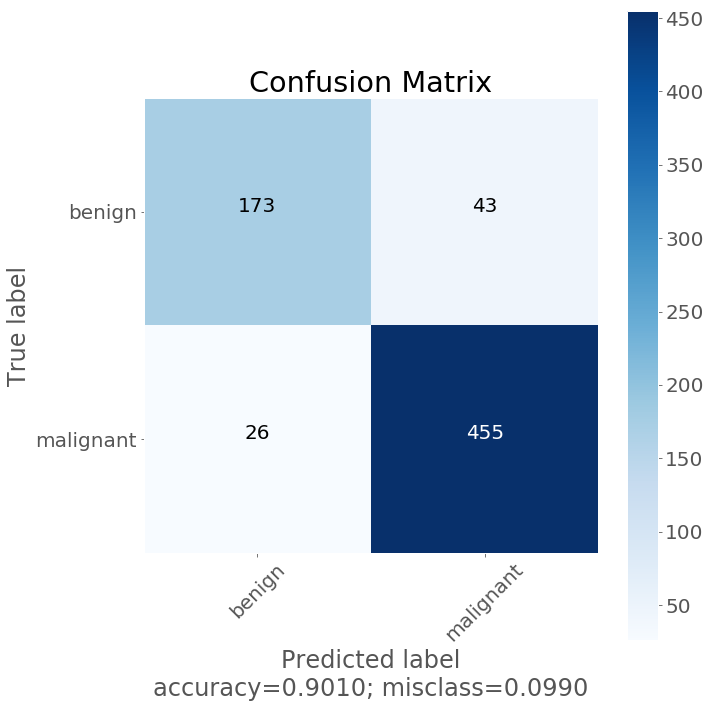

In [30]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
# fig.savefig('plots/1.Xception-CM.png') 
plt.figure(figsize=(10,10))

plot_confusion_matrix(cm, classes=labels, title='Confusion Matrix')

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report


y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[173  43]
 [ 26 455]]
              precision    recall  f1-score   support

      benign       0.87      0.80      0.83       216
   malignant       0.91      0.95      0.93       481

   micro avg       0.90      0.90      0.90       697
   macro avg       0.89      0.87      0.88       697
weighted avg       0.90      0.90      0.90       697



In [32]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  90.10043041606886
Sensitivity :  86.93467336683418
Specificity :  91.36546184738957


In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  90.1004
Precision: 91.3655
Recall:    94.5946
F1:        92.9520


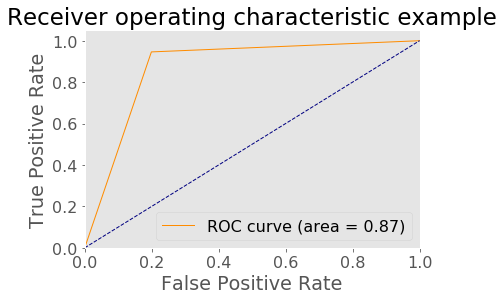

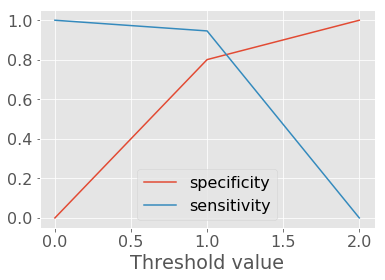

In [34]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 16})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [35]:
model.save('models/20.SEResNet50-2-BreaKHis-Model.h5')
model.save_weights('models/20.SEResNet50-2-BreaKHis-Weights.h5')

___